## Homework2 \ question 2 - VGG16 backbone Augmented

### importing dataset form drive

In [1]:
'''
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/Q2 Dataset.zip' -d '/content/dataset'
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n!unzip '/content/drive/My Drive/Q2 Dataset.zip' -d '/content/dataset'\n"

In [2]:
!pip install gdown

url = 'https://drive.google.com/uc?id=1Pf0S5a7-3cNlhcvUDjv1JLXotjMleIgt'
output = '/content/Q2 Dataset.zip'

import gdown
gdown.download(url, output, quiet=False)

!mkdir -p '/content/dataset/'


Downloading...
From: https://drive.google.com/uc?id=1Pf0S5a7-3cNlhcvUDjv1JLXotjMleIgt
To: /content/Q2 Dataset.zip
100%|██████████| 18.4M/18.4M [00:00<00:00, 54.6MB/s]


In [3]:

!unzip -q '/content/Q2 Dataset.zip' -d '/content/dataset/'


In [4]:
import numpy as np
import pandas as pd


%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import os


#### Defining hyperparams

In [5]:
NUM_CLASSES = 2

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']


NUM_CLASSES = 2  
IMAGE_RESIZE = 224
BATCH_SIZE_TRAINING = 10
BATCH_SIZE_VALIDATION = 10
NUM_EPOCHS = 50
STEPS_PER_EPOCH_TRAINING = 492 // BATCH_SIZE_TRAINING
STEPS_PER_EPOCH_VALIDATION = 210 // BATCH_SIZE_VALIDATION

BATCH_SIZE_TESTING = 1


In [6]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [7]:
ls

 dataset/  'Q2 Dataset.zip'   sample_data/


In [8]:
data_path = "/content/dataset/HW2_Dataset"  


In [9]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device:/device:GPU:0


In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


## defining a functional model
we replace the last fully connected network for our work

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler


NUM_CLASSES = 2 

input_tensor = Input(shape=(224, 224, 3))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)


for layer in base_model.layers:
    layer.trainable = False
'''
# Unfreeze the last convolutional block
conv_block_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3']
for layer in base_model.layers:
    if layer.name in conv_block_layers:
        layer.trainable = True
'''
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)  
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=outputs)


initial_lr = 0.001
decay_rate = 0.000002

# Define a learning rate scheduler
def scheduler(epoch, lr):
    """Learning rate schedule function that decreases the learning rate according to a decay rate."""
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Set up the optimizer with initial learning rate and momentum
optimizer = SGD(learning_rate=initial_lr, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

model.summary()



58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

#### initializaing dataloaders
For Augmented case

In [12]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_path = "/content/dataset/HW2_Dataset"  

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF or check your TensorFlow GPU installation.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Image data generator with preprocessing and augmentation for the training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,  # Random rotation up to 30 degrees
    zoom_range=[0.75, 1.25],  # Scaling by zooming image in and out
    horizontal_flip=True,  # Horizontal flipping of images
    validation_split=0.3  # 30% of the data will be used for validation
)

# Training generator with data augmentation
train_generator = train_datagen.flow_from_directory(
    directory=f"{data_path}/Train",
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE_TRAINING,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    subset='training'  # Set as training data
)

# Validation generator without data augmentation
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3  
)

valid_generator = valid_datagen.flow_from_directory(
    directory=f"{data_path}/Train",
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE_VALIDATION,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False,
    subset='validation'  
)

# Test generator, typically without augmentation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    directory=f"{data_path}/Test",
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    color_mode="rgb",
    batch_size=1,  
    class_mode="categorical",  
    shuffle=False,
    seed=42
)

print('Augmented')

Default GPU Device: /device:GPU:0
Found 492 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Augmented


### visualizing for Augmented case
note: we use the denormalization (only) for visulizing after augmentation because the data loader already normalized our images.

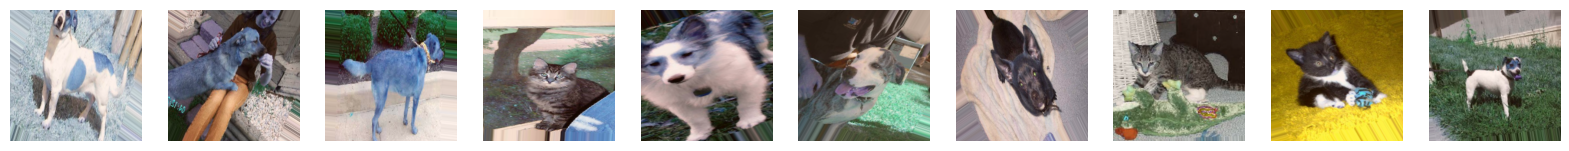

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y_batch = next(train_generator)

def rescale_images(images):
    images = images - images.min()  
    images = images / images.max() 
    return images

x_batch = rescale_images(x_batch)

fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    ax = axes[i]
    ax.imshow(x_batch[i])  
    ax.axis('off')
plt.show()



### Dataloaders for the augmented case

In [14]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(valid_generator))

(10, 50, 10, 21)

#### Training the model first time for the only last fully connected layer

In [15]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')


In [16]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 50,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks = [LearningRateScheduler(scheduler, verbose=0), cb_checkpointer]
)

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 18.1152 - accuracy: 0.8693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 29s 412ms/step - loss: 18.1152 - accuracy: 0.8693 - val_loss: 14.4264 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - 7s 149ms/step - loss: 96.4484 - accuracy: 0.8838 - val_loss: 24.5594 - val_accuracy: 0.9619 - lr: 1.0000e-03
Epoch 3/50
49/49 [==============================] - 8s 166ms/step - loss: 139.0272 - accuracy: 0.9108 - val_loss: 364.1251 - val_accuracy: 0.9381 - lr: 1.0000e-03
Epoch 4/50
49/49 [==============================] - 8s 167ms/step - loss: 350.4431 - accuracy: 0.9212 - val_loss: 161.9217 - val_accuracy: 0.9571 - lr: 9.9999e-04
Epoch 5/50
49/49 [==============================] - 8s 153ms/step - loss: 1380.9434 - accuracy: 0.8983 - val_loss: 3224.2002 - val_accuracy: 0.9619 - lr: 9.9999e-04
Epoch 6/50
49/49 [==============================] - 8s 159ms/step - loss: 2556.8740 - accuracy: 0.8817 - val_loss: 4068.3250 - val_accuracy: 0.8952 - lr: 9.9999e-04
Epoch 7/50
49/49 [==================

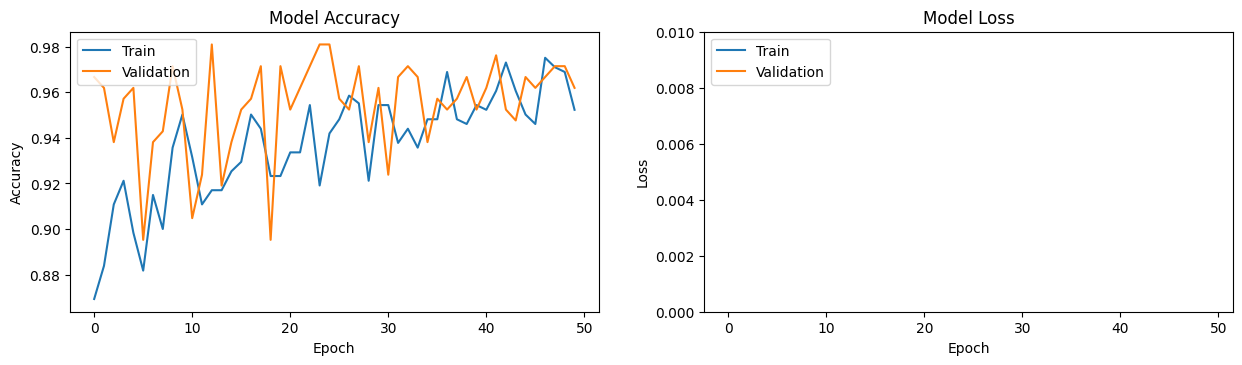

In [17]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(15, 8))

plt.subplot(221)
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0,0.01)
plt.show()


In [18]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

NUM_CLASSES = 2  

input_tensor = Input(shape=(224, 224, 3))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

for layer in base_model.layers:
    layer.trainable = False

layers_to_train = ['block5_conv1', 'block5_conv2', 'block5_conv3']

for layer in base_model.layers:
    if layer.name in layers_to_train:
        layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)  
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model2 = Model(inputs=input_tensor, outputs=outputs)

model2.load_weights('../working/best.hdf5')

outputs.trainable = True

initial_lr = 0.00001
decay_rate = 0.00000002

# Define a learning rate scheduler
def scheduler(epoch, lr):
    """Learning rate schedule function that decreases the learning rate according to a decay rate."""
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Set up the optimizer with initial learning rate and momentum
optimizer = SGD(learning_rate=initial_lr, momentum=0.9)

model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [19]:
# List all trainable layers in the model
print("Trainable Layers:")
for layer in model2.layers:
    if layer.trainable:
        print(f"- {layer.name}")


Trainable Layers:
- block5_conv1
- block5_conv2
- block5_conv3
- flatten_1
- dense_2
- dropout_1
- dense_3


In [20]:
# List all non-trainable layers in the model
print("Non-Trainable Layers:")
for layer in model2.layers:
    if not layer.trainable:
        print(f"- {layer.name}")

Non-Trainable Layers:
- input_2
- block1_conv1
- block1_conv2
- block1_pool
- block2_conv1
- block2_conv2
- block2_pool
- block3_conv1
- block3_conv2
- block3_conv3
- block3_pool
- block4_conv1
- block4_conv2
- block4_conv3
- block4_pool
- block5_pool


In [21]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_checkpointer2 = ModelCheckpoint(filepath = '../working/best2.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')


In [22]:
fit_history = model2.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 50,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks = [LearningRateScheduler(scheduler, verbose=0), cb_checkpointer2]
)

Epoch 1/50
49/49 [==============================] - 15s 270ms/step - loss: 10.7124 - accuracy: 0.8880 - val_loss: 2.2281 - val_accuracy: 0.9238 - lr: 1.0000e-05
Epoch 2/50
49/49 [==============================] - 9s 184ms/step - loss: 1.0939 - accuracy: 0.8921 - val_loss: 1.3606 - val_accuracy: 0.9190 - lr: 1.0000e-05
Epoch 3/50
49/49 [==============================] - 9s 177ms/step - loss: 0.5537 - accuracy: 0.9212 - val_loss: 0.9641 - val_accuracy: 0.9333 - lr: 1.0000e-05
Epoch 4/50
49/49 [==============================] - 9s 187ms/step - loss: 0.7338 - accuracy: 0.9295 - val_loss: 0.6103 - val_accuracy: 0.9286 - lr: 1.0000e-05
Epoch 5/50
49/49 [==============================] - 9s 176ms/step - loss: 0.1479 - accuracy: 0.9461 - val_loss: 0.7420 - val_accuracy: 0.9429 - lr: 1.0000e-05
Epoch 6/50
49/49 [==============================] - 8s 163ms/step - loss: 0.1335 - accuracy: 0.9647 - val_loss: 1.5300 - val_accuracy: 0.9667 - lr: 1.0000e-05
Epoch 7/50
49/49 [==========================

In [23]:
model2.save('../working/full_model.h5')


In [24]:
print(fit_history.history.keys())



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


## Visualizing final model train-dev set ouput

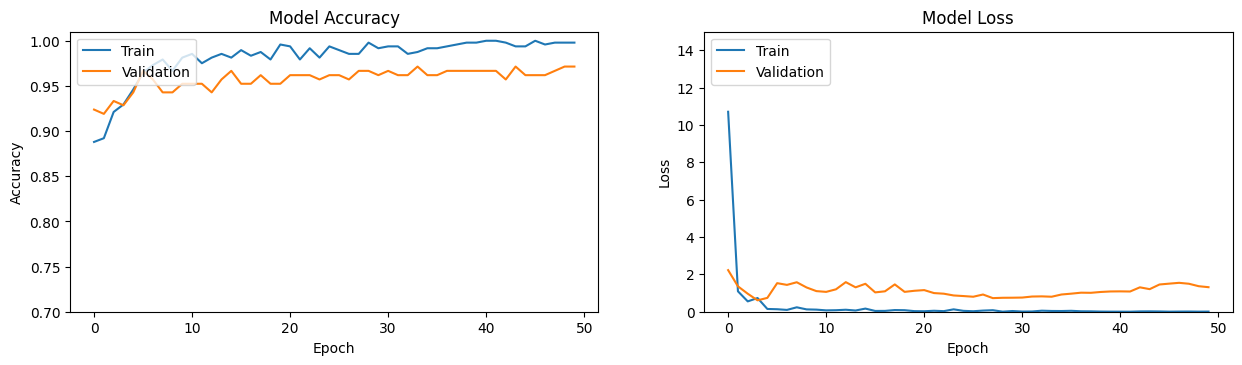

In [32]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(15, 8))

plt.subplot(221)
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.7,1.01)

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0,15)

plt.show()

In [26]:
ls

 dataset/  'Q2 Dataset.zip'   sample_data/


### Test set accuracy

In [27]:
test_generator.reset()
pred = model2.predict(test_generator, steps=np.ceil(len(test_generator.filenames) / BATCH_SIZE_TESTING), verbose=1)

predicted_class_indices = np.argmax(pred, axis=1) if pred.shape[-1] > 1 else (pred > 0.5).astype('int32')

true_class_indices = test_generator.classes

# Calculate accuracy
correct_predictions = np.sum(predicted_class_indices == true_class_indices)
total_predictions = len(predicted_class_indices)
test_accuracy = correct_predictions / total_predictions

print(f"Test Accuracy: {test_accuracy:.2f}")


100/100 [==============================] - 2s 9ms/step
Test Accuracy: 0.96


## Accuracy and confustion matrix of the resultant network

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(true_class_indices, predicted_class_indices)
print("Confusion Matrix:\n", cm)

report = classification_report(true_class_indices, predicted_class_indices, target_names=['Class1', 'Class2'])
print("\nClassification Report:\n", report)


Confusion Matrix:
 [[47  3]
 [ 1 49]]

Classification Report:
               precision    recall  f1-score   support

      Class1       0.98      0.94      0.96        50
      Class2       0.94      0.98      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



## Visualizing for testing case

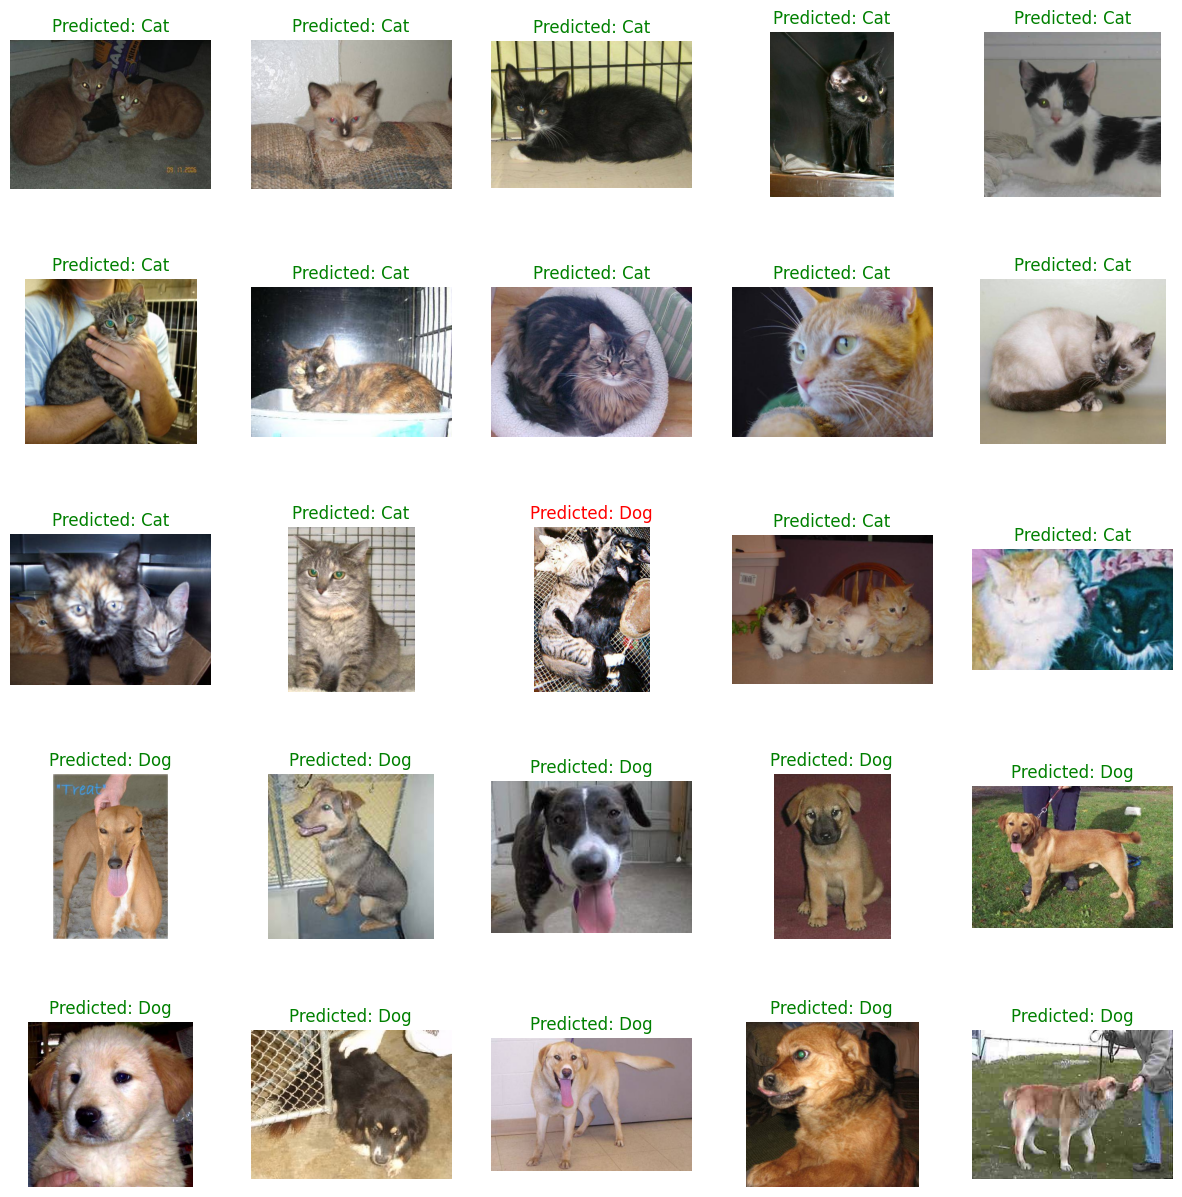

In [29]:
import cv2
import matplotlib.pyplot as plt
import os

data_path = "/content/dataset/HW2_Dataset"
TEST_DIR = f"{data_path}/Test"
num_images = 25  

f, ax = plt.subplots(5, 5, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': [], 'frame_on': True})

for i in range(25):
    img_path = os.path.join(TEST_DIR, test_generator.filenames[i+35])
    imgBGR = cv2.imread(img_path)
    if imgBGR is None:
        print("Failed to load image at:", img_path)
        continue  

    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    true_class_indices = test_generator.classes

    predicted_class = "Dog" if predicted_class_indices[i+35] == 1 else "Cat"
    true_class = "Dog" if true_class_indices[i+35] == 1 else "Cat"
    is_correct = predicted_class == true_class

    edge_color = 'green' if is_correct else 'red'
    title_color = 'green' if is_correct else 'red'  

    ax[i // 5, i % 5].imshow(imgRGB)
    ax[i // 5, i % 5].set_frame_on(True)
    ax[i // 5, i % 5].spines['bottom'].set_color(edge_color)
    ax[i // 5, i % 5].spines['top'].set_color(edge_color)
    ax[i // 5, i % 5].spines['right'].set_color(edge_color)
    ax[i // 5, i % 5].spines['left'].set_color(edge_color)
    ax[i // 5, i % 5].spines['bottom'].set_linewidth(5)
    ax[i // 5, i % 5].spines['top'].set_linewidth(5)
    ax[i // 5, i % 5].spines['right'].set_linewidth(5)
    ax[i // 5, i % 5].spines['left'].set_linewidth(5)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_title(f"Predicted: {predicted_class}", color=title_color)

f.subplots_adjust(hspace=0.5)

plt.show()
